# Семинар 6: предобработка данных и функции потерь в линейной регрессии

## Вступление
Сегодня мы продолжим обсуждать предобработку данных, добавив к ней генерацию новых признаков. Потом обсудим различные функции потерь для линейной регрессии, визуально сравним их. Ну и закончим тем, чего все давно ждали: познакомимся подробнее с интерфейсами линейных моделей и методов отбора признаков в sklearn, обучим ряд линейных моделей.

### План семинара
1. Предоработка данных
    - Заполнение пропусков
    - Преобразование нечисловых признаков
    - Масштабирование
    - Генерация новых признаков
2. Имплементация и визуализация функций потерь для регрессии
    - MSE, RMSE, R2 score
    - MAE
    - Huber Loss
    - Logarithmic Loss
    - Quantile Loss
3. Обучение линейных моделей и отбор признаков

## 1. Предоработка данных
Для демонстраций загрузим набор данных [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/Automobile). В данных присутствуют категориальные, целочисленные и вещественнозначные признаки.

In [3]:
import warnings

import matplotlib
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 8)

In [4]:
X_raw = pd.read_csv(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data",
    header=None,
    na_values=["?"],
)

y = X_raw[25]
X_raw = X_raw.drop(25, axis=1)

X_raw.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,...,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,...,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,...,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,...,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22


#### Заполним пропуски средними и пустыми строками

In [5]:
# создаем маску, указывающую на столбцы с категориальными признаками
cat_features_mask = (X_raw.dtypes == "object").values

# для вещественнозначных признаков заполним пропуски средними
X_real = X_raw[X_raw.columns[~cat_features_mask]]
mis_replacer = SimpleImputer(strategy="mean")
X_no_mis_real = pd.DataFrame(
    data=mis_replacer.fit_transform(X_real), columns=X_real.columns
)

# для категориальных — пустыми строками
X_cat = X_raw[X_raw.columns[cat_features_mask]].fillna("")
X_no_mis = pd.concat([X_no_mis_real, X_cat], axis=1)

#### Преобразуем нечисловые признаки при помощи one-hot encoding

In [6]:
X_dum = pd.get_dummies(X_no_mis, drop_first=True)
print(f"Data shape: {X_dum.shape}")
X_dum.head()

Data shape: (205, 66)


,0,1,9,10,11,12,13,16,18,19,...,15_three,15_twelve,15_two,17_2bbl,17_4bbl,17_idi,17_mfi,17_mpfi,17_spdi,17_spfi
0,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,0,0,0,0,0,0,0,1,0,0
1,3.0,122.0,88.6,168.8,64.1,48.8,2548.0,130.0,3.47,2.68,...,0,0,0,0,0,0,0,1,0,0
2,1.0,122.0,94.5,171.2,65.5,52.4,2823.0,152.0,2.68,3.47,...,0,0,0,0,0,0,0,1,0,0
3,2.0,164.0,99.8,176.6,66.2,54.3,2337.0,109.0,3.19,3.40,...,0,0,0,0,0,0,0,1,0,0
4,2.0,164.0,99.4,176.6,66.4,54.3,2824.0,136.0,3.19,3.40,...,0,0,0,0,0,0,0,1,0,0


#### Отмасштабируем признаки MinMaxScaler'ом

In [7]:
normalizer = MinMaxScaler()
X_real_norm_np = normalizer.fit_transform(X_dum)
X = pd.DataFrame(data=X_real_norm_np)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,64,65
0,1.0,0.298429,0.058309,0.413433,0.316667,0.083333,0.411171,0.260377,0.664286,0.290476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.298429,0.058309,0.413433,0.316667,0.083333,0.411171,0.260377,0.664286,0.290476,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.6,0.298429,0.230321,0.449254,0.433333,0.383333,0.517843,0.343396,0.100000,0.666667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.8,0.518325,0.384840,0.529851,0.491667,0.541667,0.329325,0.181132,0.464286,0.633333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.8,0.518325,0.373178,0.529851,0.508333,0.541667,0.518231,0.283019,0.464286,0.633333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


#### Сгенерируем новые признаки
Особенно важным моментом для линейной регрессии является нелинейное преобразование признаков. Это позволяет использовать линейную регрессию для моделирования нелинейных зависимостей.

Наиболее популярны такие преобразования:
- добавление полиномиальных признаков (`PolynomialFeatures` в sklearn)
- взятие логарифма признака
- взятие квадратного корня
- применение тригонометрических функций

Делать добавление признаков нужно с умом: большое количество полиномиальных и прочих новых признаков может сильно раздуть размер таблицы с данными, что может негативно сказаться на скорости и качестве моделирования.

Небольшой пример. Посмотрев на наши данные, мы можем заметить, что зависимость целевой переменной от шестого признака скорее квадратичная, чем линейная:

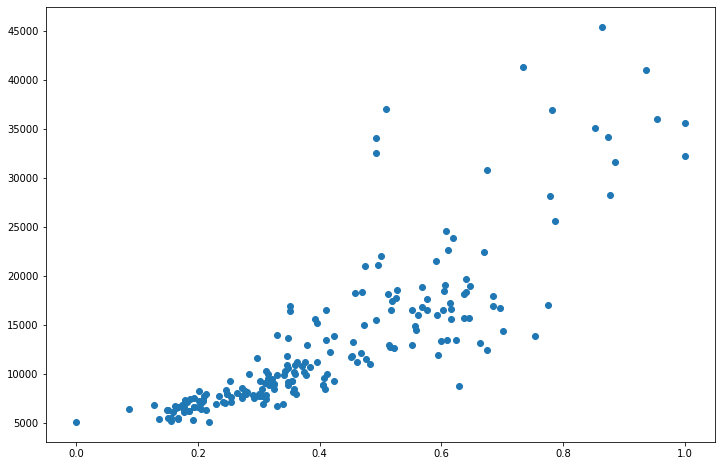

In [8]:
plt.scatter(X[6], y)
plt.show();

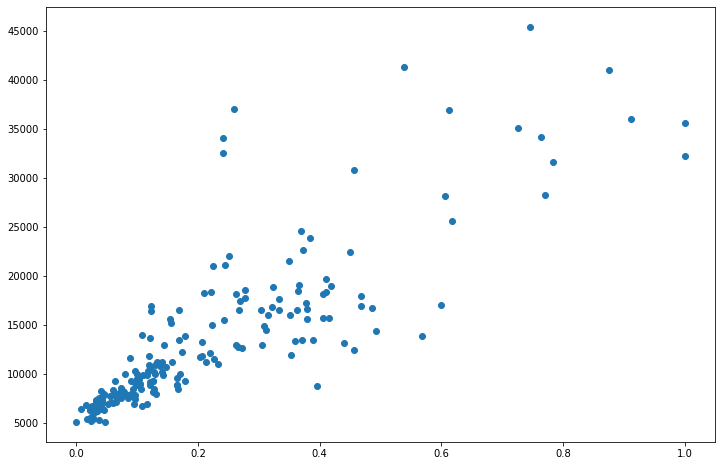

In [9]:
plt.scatter(X[6] ** 2, y)
plt.show();

А для признака номер 13 линеаризовать зависимость получается с помощью функции $\frac 1 {\sqrt{x}}$:

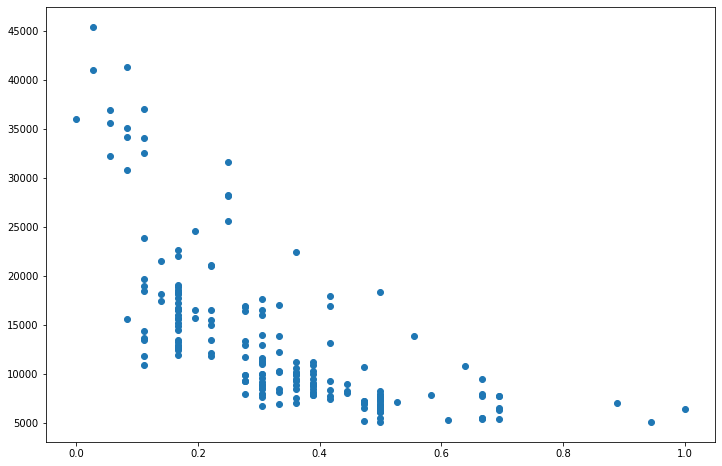

In [10]:
plt.scatter(X[13], y)
plt.show();

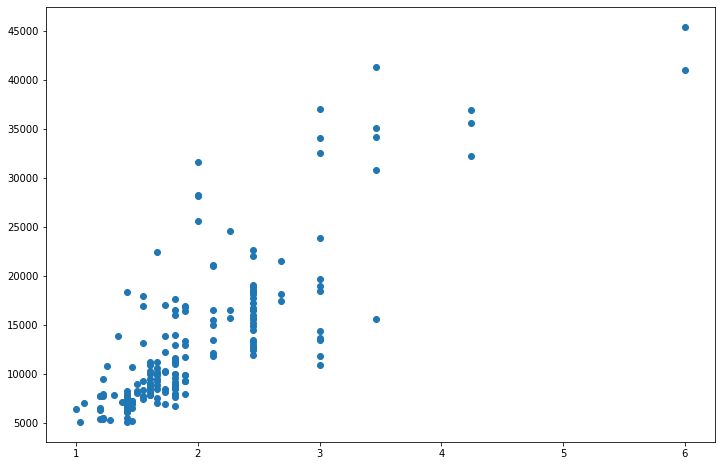

In [11]:
plt.scatter(1 / np.sqrt(X[13]), y)
plt.show();

## 2. Имплементация и визуализация функций потерь для регрессии

Функционал качества в задачах обучения с учителем обычно задается в виде суммы по объектам выборки:
$$Q(a) = \frac 1 \ell \sum_{i=1}^\ell L(y_i, a(x_i)),$$
где $L(\cdot, \cdot)$ - функция потерь, задающая штраф за разницу между предсказанием и истинным значением целевого признака. Свойства функции потерь:
* $L(y_i, a(x_i)) \geqslant 0$;
* $L(y_i, y_i) = 0$.

Функционал качества должен в первую очередь отвечать требованиям заказчика, при этом математические свойства функции потерь могут быть неудобны для оптимизации.

__Пример:__ если мы не различаем маленькие ошибки (между 0.01 и 0.1 нет особой разницы), но зато не хотим получать большие ошибки, можно использовать следующую функцию потерь:

$$L(y_i, a(x_i)) = [| y_i - a(x_i) | < \varepsilon],$$ $\varepsilon$ — допустимая разница между предсказанием и фактом.

### MSE, RMSE, R2 score
Кроме требований заказчика, функционал качества должен учитывать математические особенности модели, например, устойчивость к шумовым объектам.

В линейной регрессии Mean Squared Error: $L(y_i, a(x_i)) = (a(x_i) - y_i)^2$ не обладает этим свойством, потому что задает очень большие штрафы за большие отклонения от фактического значения.

$$MSE (a, X, Y) = \sum^L_{i=1}(a(x_i) - y_i)^2$$

Рассмотрим это явление на примере. Выберем один признак, от которого целевой признак (имеющий индекс 15 в матрице X) зависит практически линейно. Добавим к выборке два объекта-выброса и посмотрим, как изменится оптимизированная на MSE прямая.


In [12]:
X_subset = X[[7, 15]].values
X_subset_modified = np.vstack(
    (X_subset, [[1, 90], [2, 50]])
)  # добавление двух шумовых точек

In [13]:
def scatter_points_and_plot_line_MSE(
    X_subset: np.array, ax: matplotlib.axes._axes.Axes
) -> None:
    # визуализируем точки
    ax.scatter(X_subset[:, 0], X_subset[:, 1])

    # обучим линейную модель
    lr = LinearRegression()
    lr.fit(X_subset[:, 0][:, np.newaxis], X_subset[:, 1])

    # визуализируем прямую
    grid = np.linspace(0, 2, 100)
    line = lr.predict(grid[:, np.newaxis])
    ax.plot(grid, line)
    ax.set_ylim(-20, 100)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

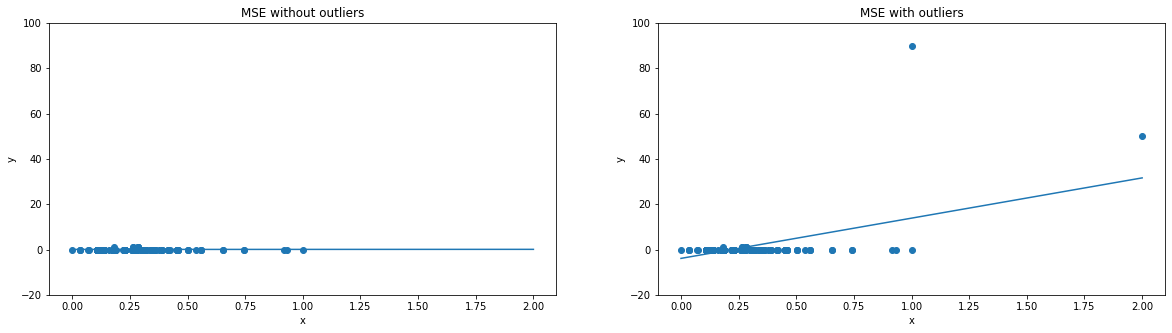

In [14]:
_, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].set_title("MSE without outliers")
scatter_points_and_plot_line_MSE(X_subset, ax[0])
ax[1].set_title("MSE with outliers")
scatter_points_and_plot_line_MSE(X_subset_modified, ax[1])
plt.show();

**Задание.** Реализуйте функцию для подсчета MSE с использованием numpy.

In [15]:
def MSE(y: np.array, y_pred: np.array) -> np.float64:
    return ((y - y_pred) ** 2).mean()


a = np.array([11, 20, 19, 17, 10])
pred = np.array([12, 18, 19.5, 18, 9])
mse = MSE(y=a, y_pred=pred)
print(f"Mean Square Error is: {mse}")
assert mse == 1.45

Mean Square Error is: 1.45


Среднеквадратичная ошибка подходит для сравнения двух моделей или для контроля качества во время обучения. Из-за того, разница возводится в квадрат, сложно дать этому числу интерпретацию. Для лучшей интерпретации используется Root Mean Square Error (RMSE): её значение имеет те же масштабы, что и целевая переменная.

$$RMSE (a, X, Y) = \sqrt{MSE (a, X)} = \sqrt{ \sum^L_{i=1}(a(x_i) - y_i)^2}$$

**Задание.** Реализуйте функцию для подсчета RMSE с использованием numpy.

In [16]:
def RMSE(y: np.array, y_pred: np.array) -> np.float64:
    return np.sqrt(MSE(y, y_pred))


rmse = RMSE(y=a, y_pred=pred)
print(f"Root Mean Square Error is: {rmse}")
assert rmse == 1.2041594578792296

Root Mean Square Error is: 1.2041594578792296


Коэффициент детерминации $R^2$ показывает долю дисперсии в целевой переменной, которая объяснена зависимыми переменными. $R^2$ можно интерпретировать как некоторого рода нормированное MSE.

$$R^2(a, X, Y) = 1 - \frac {\sum^L_{i=1}(a(x_i) - y_i)^2}{\sum^L_{i=1}(y_i - \bar{y})^2}$$

- Если $R^2 < 0$, значит наша модель даёт предсказание хуже константы в виде среднего значения целевой переменной, то есть абсолютно бесполезна с точки зрения MSE.
- Если $R^2 = 0$, значит мы предсказываем не лучше и не хуже константы в виде среднего значения целевой переменной.
- Если $0 < R^2 < 1$, значит модель работает лучше константного предсказания с точки зрения MSE.
- Если $R^2 = 1$, значит ошибка MSE равна нулю. Это может произойти, например, при полном переобучении на тренировочной части выборки.

**Задание.** Реализуйте функцию для подсчета $R^2$ с использованием numpy.

In [17]:
def R_squared(y: np.array, y_pred: np.array) -> np.float64:
    return 1 - MSE(y, y_pred) / MSE(y, y.mean())


r_squared = R_squared(y=a, y_pred=pred)
print(f"R2 score is: {r_squared}")

R2 score is: 0.914906103286385


### MAE
Из-за того, что в MSE мы учитываем квадрат отклонения, шумовые объекты могут сильно изменить наклон прямой. Поэтому в качестве альтернативы MSE можно использовать Mean Absolute Error: $L(y_i, a(x_i)) = |a(x_i) - y_i|$.

$$MAE(a, X, Y) = \frac {1}{L} \sum^L_{i=1}|a(x_i) - y_i|$$

Теперь обучим регрессию, оптимизируя MAE. В `sklearn` такая регрессия не реализована, но можно использовать модуль `statsmodels`. Более формально, необходимая модель может быть получена с помощью обучения квантильной регрессии с параметром `q=0.5`.

**Задание.** Реализуйте функцию для подсчета MAE с использованием numpy.

In [18]:
def MAE(y: np.array, y_pred: np.array) -> np.float64:
    return np.abs(y - y_pred).mean()


mae = MAE(y=a, y_pred=pred)
print(f"Mean Absolute Error is: {mae}")
assert mae == 1.1

Mean Absolute Error is: 1.1


In [19]:
# !pip install git+https://github.com/statsmodels/statsmodels

In [1]:
import statsmodels.formula.api as smf

In [20]:
def scatter_points_and_plot_line_MAE(
    X_subset: np.array, ax: matplotlib.axes._axes.Axes
) -> None:
    # визуализируем точки
    ax.scatter(X_subset[:, 0], X_subset[:, 1])

    # задаем зависимость переменной f15 от переменной f7 и передаем данные
    mod = smf.quantreg("f15 ~ f7", pd.DataFrame(data=X_subset, columns=["f7", "f15"]))
    res = mod.fit(q=0.5)

    # визуализируем прямую
    grid = np.linspace(0, 2, 100)
    line = grid * res.params["f7"] + res.params["Intercept"]
    ax.plot(grid, line)
    ax.set_ylim(-20, 100)
    ax.set_xlabel("x")
    ax.set_ylabel("y")

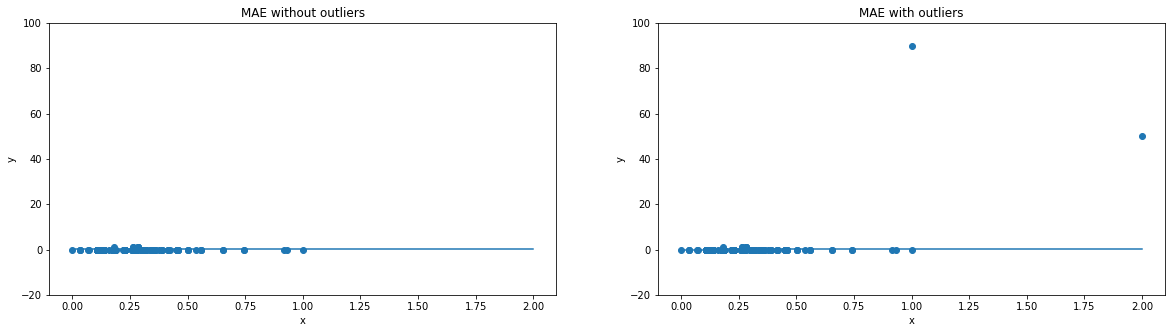

In [21]:
_, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].set_title("MAE without outliers")
scatter_points_and_plot_line_MAE(X_subset, ax[0])
ax[1].set_title("MAE with outliers")
scatter_points_and_plot_line_MAE(X_subset_modified, ax[1])
plt.show();

Прямая практически не изменила направление из-за выбросов! Попробуем добавить больше шумовых объектов.

In [22]:
np.random.seed(13)
X_subset_modified_twice = np.vstack(
    (X_subset_modified, np.random.randint(5, size=60).reshape(-1, 2) * [1, 30])
)

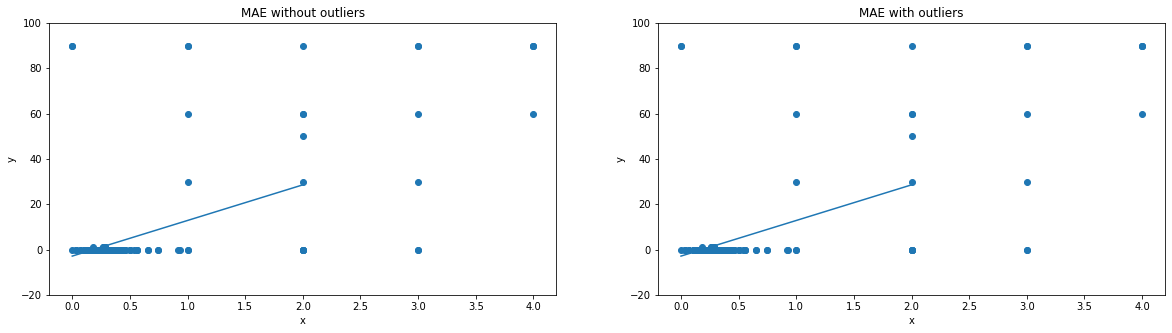

In [23]:
_, ax = plt.subplots(1, 2, figsize=(20, 5))
ax[0].set_title("MAE without outliers")
scatter_points_and_plot_line_MAE(X_subset_modified_twice, ax[0])
ax[1].set_title("MAE with outliers")
scatter_points_and_plot_line_MAE(X_subset_modified_twice, ax[1])
plt.show();

Под таким количеством выбросов, изменилась даже регрессия над MAE.

#### Оптимальные константы для MSE и MAE

Допустим алгоритм возвращает константное предсказание: $a(x) = C, C \in R$. В качестве примера такого алгоритма можно представить предсказание прибыли в январе константой, равной средней прибыли за январь всех предыдущих лет работы.

**Задание.** Найдите $C$, минимизирующий среднеквадратичную ошибку.

**Решение.** Нам необходимо найти константу C, минимизирующую функцию $\frac{1}{n} \sum_{i}^{n} (C - y_i)^2$. Для этого возьмём производную этой функции и приравняем её к нулю. Константы сразу можно сократить: $\sum_{i}^{n} (C - y_i) = 0$. Преобразуем это выражение и выпишем ответ: $C = \frac{\sum_{i}^{n} y_i}{n}$. То есть оптимальная константа — среднее значение целевой переменной.

**Задание.** Найдите $C$, минимизирующий среднюю абсолютную ошибку.
TBD

### Huber Loss
Иногда используют "гибрид" MAE и MSE, который, как и MAE, устойчив к шумовым объектам, и, как и MSE, мало штрафует малые отклонения от фактического значения целевого признака. Этот гибрид называется Huber Loss:

$$L_i(y_i, a(x_i)) = \phi_\varepsilon(a(x_i) - y_i)$$
$$\phi_\varepsilon(z) = \begin{cases} \frac 1 2 z^2, - \varepsilon < z < \varepsilon, \\\varepsilon (|z| - \frac 1 2 \varepsilon), иначе \\ \end{cases}$$

Можно проверить, что у этой функции существует непрерывная первая производная во всех точках.

Оптимизация Huber Loss реализована в sklearn.

**Задание.** Реализуйте функцию для подсчета Huber Loss с использованием numpy.

In [30]:
def Huber(y: np.array, y_pred: np.array, eps: float = 1) -> np.float64:
    delta = y - y_pred
    cond = (delta < eps) & (delta > -eps)
    print(cond)
    res = np.zeros_like(y)
    res[cond] = delta[cond] ** 2 / 2
    print(res)
    res[~cond] = eps * (abs(delta[~cond]) - eps * 0.5)
    print(res)
    return res.mean()


huber = Huber(y=a, y_pred=pred, eps=1)
print("Huber Loss is:", huber)

[False False  True False False]
[0 0 0 0 0]
[0 1 0 0 0]
Huber Loss is: 0.2


### Mean Squared Logarithmic Error (MSLE)

Эта функция потерь применяется в случаях, когда лучше получать заниженные прогнозы, нежели завышенные. Ещё она полезна, когда нас больше интересует правильно попасть в порядок целевой переменной, чем в её конкретное значение. Обратите внимание, что из-за присутствия логарифма в формуле **целевая переменная должна быть неотрицательной**. Единицу добавляем, чтобы случайно не получить логарифм нуля.

$$L_i(a, X_i, Y_i) = (\log(a(x_i)+1) - \log(y_i+1))^2$$

**Задание.** Реализуйте функцию для подсчета MSLE с использованием numpy.

In [31]:
def MSLE(y: np.array, y_pred: np.array) -> np.float64:
    return ((np.log(y + 1) - np.log(y_pred + 1)) ** 2).mean()


msle = MSLE(y=a, y_pred=pred)
print(f"Mean Squared Logarifmic Error is: {msle}")

Mean Squared Logarifmic Error is: 0.005808110727039668


### Quantile Loss
В некоторых задачах штраф за ошибку зависит не только от величины абсолютного отклонения от фактического значения, но и от знака этого отклонения. Например, лучше предсказать спрос больше, чем будет по факту, чем меньше, потому что во втором случае будет потеряна прибыль. В этом случае используется квантильная регрессия со следующей функцией потерь:
$$L_i(y_i, a(x_i)) = \rho_\tau(y_i - x_i^T w),$$
$$\rho_\tau(z) = \begin{cases} \tau z, \quad z > 0, \\ (\tau - 1) z, \quad z \leqslant 0 \end{cases}$$
Параметр $\tau \in (0, 1)$ влияет на то, насколько различаются штрафы за положительную и отрицательную разницу.

Изобразим график квантильной функции потерь вместе с некоторыми другими рассмотренными:

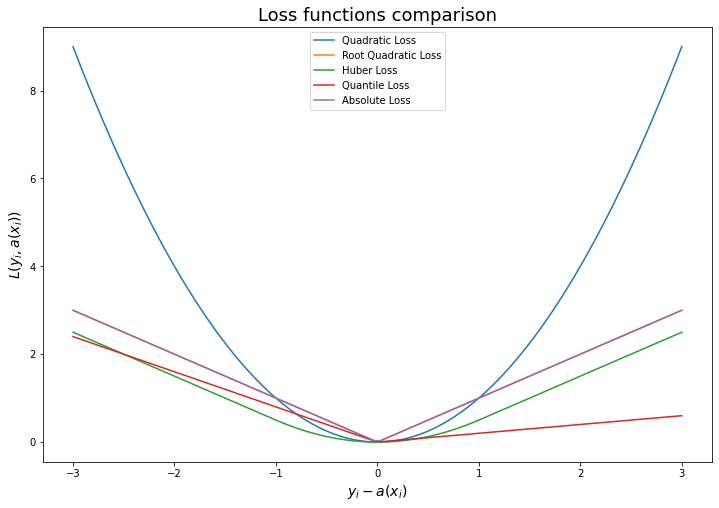

In [33]:
grid = np.linspace(-3, 3, 100)
quantile_tau = 0.2
mse_loss = grid**2
rmse_loss = np.sqrt(mse_loss)
mae_loss = np.abs(grid)
huber_loss = (
    0.5 * mse_loss * (grid >= -1) * (grid <= 1)
    + (mae_loss - 0.5) * (grid < -1)
    + (mae_loss - 0.5) * (grid > 1)
)
quantile_loss = quantile_tau * grid * (grid > 0) + (quantile_tau - 1) * grid * (
    grid <= 0
)
plt.plot(grid, mse_loss, label="Quadratic Loss")
plt.plot(grid, rmse_loss, label="Root Quadratic Loss")
plt.plot(grid, huber_loss, label="Huber Loss")
plt.plot(grid, quantile_loss, label="Quantile Loss")
plt.plot(grid, mae_loss, label="Absolute Loss")
plt.xlabel("$y_i - a(x_i)$", fontsize=14)
plt.ylabel("$L(y_i, a(x_i))$", fontsize=14)
plt.title("Loss functions comparison", fontsize=18)
plt.legend()
plt.show()

## 3. Обучение линейных моделей и отбор признаков

Мы поработаем с данными о сообществах в США. Будем предсказывать количество насильственных преступлений относительно численности населения.

[Описание датасета](http://archive.ics.uci.edu/ml/datasets/communities+and+crime)
[Датасет на кэггле](https://www.kaggle.com/kkanda/communities%20and%20crime%20unnormalized%20data%20set)

In [34]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler

In [37]:
data = pd.read_csv("https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2023/seminars/sem06_linreg/crimedata.csv", na_values=["?"])

# оставим лишь нужные колонки
requiredColumns = [5, 6] + list(range(11, 26)) + list(range(32, 103)) + [145]
data = data[data.columns[requiredColumns]]

# некоторые значения целевой переменной пропущены
X = data.loc[data["ViolentCrimesPerPop"].notnull(), :].drop(
    "ViolentCrimesPerPop", axis=1
)
y = data["ViolentCrimesPerPop"][X.index]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

### Baseline
Обучим линейную регрессию и выведем качество по метрике MSE на обучающей и тестовой выборке.

In [38]:
lr = LinearRegression().fit(X_train, y_train)
print(f"Train: {mean_squared_error(y_train, lr.predict(X_train))}")
print(f"Test: {mean_squared_error(y_test, lr.predict(X_test))}")

Train: 118390.69446924048
Test: 229491.8526154825


Популярным решением для регрессионных моделей является **регуляризация**.

Во время оптимизации линейной регрессии, веса при переменных могут получиться большими в абсолютных значениях. Это не очень хорошо, поскольку классификатор будет чувствителен к крайне маленьким изменениям в признаках объекта, а значит, переобучен. Для решения проблемы к функционалу ошибки добавляют регуляризатор, который "штрафует" модель за слишком большую норму вектора весов:

$$Q\alpha(w) = Q(w) + \alpha R(w)$$ 

где $R(w)$ — регуляризатор

Наиболее распространенными являются L1 и L2 регуляризаторы:
$$L1: R(w) = ||w||_1 = \sum^d_i w_i^2$$

$$L2: R(w) = ||w||_2 = \sum^d_i |w_i|$$

Давайте применим каждый из них к нашей задаче и посмотрим на изменение в результатах.


In [39]:
lasso = Lasso(5.0).fit(X_train, y_train)
print("Lasso")
print(f"Train: {mean_squared_error(y_train, lasso.predict(X_train))}")
print(f"Test: {mean_squared_error(y_test, lasso.predict(X_test))}")

ridge = Ridge(5.0).fit(X_train, y_train)
print("\nRidge")
print(f"Train: {mean_squared_error(y_train, ridge.predict(X_train))}")
print(f"Test: {mean_squared_error(y_test, ridge.predict(X_test))}")

Lasso
Train: 120759.04247413314
Test: 234547.34217759452

Ridge
Train: 118756.91752916541
Test: 230027.2784349967


### Scaling
Попробуем MinMaxScaler.

In [44]:
sc = MinMaxScaler()
X_train_scaled = pd.DataFrame(data=sc.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(data=sc.transform(X_test), columns=X_test.columns)

**Задание.** Напишите код обучения линейной регрессии на масштабированных признаках и выведите ошибку на обучающей и тестовой выборках.

In [46]:
lr = LinearRegression().fit(X_train_scaled, y_train)
print(f"Train: {mean_squared_error(y_train, lr.predict(X_train_scaled))}")
print(f"Test: {mean_squared_error(y_test, lr.predict(X_test_scaled))}")

Train: 118448.22464043887
Test: 227463.437154386


**Задание:** проделайте аналогичную работу, добавив Ridge регуляризацию

In [47]:
ridge = Ridge(5.0).fit(X_train_scaled, y_train)
print("\nRidge")
print(f"Train: {mean_squared_error(y_train, ridge.predict(X_train_scaled))}")
print(f"Test: {mean_squared_error(y_test, ridge.predict(X_test_scaled))}")


Ridge
Train: 128928.78005161337
Test: 190354.7380702171


### Отбор признаков на основе дисперсии

Полезны ли признаки, имеющие высокую дисперсию? А низкую?

In [48]:
features_variance = X_train_scaled.var().sort_values(ascending=False)
features_variance.head()

pctUrban          0.198050
RentHighQ         0.062216
MedYrHousBuilt    0.054286
OwnOccHiQuart     0.047559
MedRent           0.046091
dtype: float64

Попробуем удалить признаки с самой низкой дисперсией и посмотреть, как изменится качество. В sklearn есть специальный инструмент для такого наивного отбора признаков. Стоит ли нормализовать перед этим признаки?

In [49]:
from sklearn.feature_selection import VarianceThreshold

In [50]:
# можно убрать все признаки, дисперсия которых меньше заданного значения
vs_transformer = VarianceThreshold(0.01)

X_train_var = pd.DataFrame(
    data=vs_transformer.fit_transform(X_train_scaled),
    columns=X_train_scaled.columns[vs_transformer.get_support()],
)
X_test_var = pd.DataFrame(
    data=vs_transformer.transform(X_test_scaled),
    columns=X_test_scaled.columns[vs_transformer.get_support()],
)

X_train_var.shape

(1595, 73)

In [51]:
lr = LinearRegression().fit(X_train_var, y_train)
print(f"Train: {mean_squared_error(y_train, lr.predict(X_train_var))}")
print(f"Test: {mean_squared_error(y_test, lr.predict(X_test_var))}")

Train: 126315.27993981192
Test: 157674.10736115288


In [52]:
ridge = Ridge(5.0).fit(X_train_var, y_train)
print(f"Train: {mean_squared_error(y_train, ridge.predict(X_train_var))}")
print(f"Test: {mean_squared_error(y_test, ridge.predict(X_test_var))}")

Train: 134727.58498424906
Test: 163362.28929027697


### Отбор признаков на основе корреляции с целевой переменной
Можно выбрать k признаков, которые дают наиболее высокие значения корреляции с целевой переменной.

In [54]:
from sklearn.feature_selection import SelectKBest, f_regression

In [55]:
# Выбираем 15 лучших признаков
sb = SelectKBest(f_regression, k=15)

X_train_kbest = pd.DataFrame(
    data=sb.fit_transform(X_train_var, y_train),
    columns=X_train_var.columns[sb.get_support()],
)
X_test_kbest = pd.DataFrame(
    data=sb.transform(X_test_var), columns=X_test_var.columns[sb.get_support()]
)

In [56]:
lr = LinearRegression().fit(X_train_kbest, y_train)
print(f"Train: {mean_squared_error(y_train, lr.predict(X_train_kbest))}")
print(f"Test: {mean_squared_error(y_test, lr.predict(X_test_kbest))}")

Train: 146478.7820172876
Test: 160372.2352378487


In [57]:
ridge = Ridge(5.0).fit(X_train_kbest, y_train)
print(f"Train: {mean_squared_error(y_train, ridge.predict(X_train_kbest))}")
print(f"Test: {mean_squared_error(y_test, ridge.predict(X_test_kbest))}")

Train: 155592.6871109259
Test: 178691.63162101313


А можно выбрать самые значимые признаки с точки зрения регрессии с $L_1$-регуляризацией.

In [58]:
from sklearn.feature_selection import SelectFromModel

In [59]:
lasso = Lasso(5.0)
l1_select = SelectFromModel(lasso)

X_train_l1 = pd.DataFrame(
    data=l1_select.fit_transform(X_train_var, y_train),
    columns=X_train_var.columns[l1_select.get_support()],
)
X_test_l1 = pd.DataFrame(
    data=l1_select.transform(X_test_var),
    columns=X_test_var.columns[l1_select.get_support()],
)

X_train_l1.shape

(1595, 10)

In [60]:
lr = LinearRegression().fit(X_train_l1, y_train)
print(f"Train: {mean_squared_error(y_train, lr.predict(X_train_l1))}")
print(f"Test: {mean_squared_error(y_test, lr.predict(X_test_l1))}")

ridge = Ridge(5.0).fit(X_train_l1, y_train)
print(f"Train: {mean_squared_error(y_train, ridge.predict(X_train_l1))}")
print(f"Test: {mean_squared_error(y_test, ridge.predict(X_test_l1))}")

Train: 140633.82259967245
Test: 161202.08743230256
Train: 142251.60315852886
Test: 168226.9650141962


### Зададим все преобразования, отбор признаков и обучение при помощи Pipeline

In [61]:
from sklearn.pipeline import Pipeline

pipe = Pipeline(
    steps=[
        ("scaler", MinMaxScaler()),
        ("variance", VarianceThreshold(0.01)),
        ("selection", SelectFromModel(Lasso(5.0))),
        ("regressor", Ridge(5.0)),
    ]
)

pipe.fit(X_train, y_train)

pipe.named_steps

{'scaler': MinMaxScaler(),
 'variance': VarianceThreshold(threshold=0.01),
 'selection': SelectFromModel(estimator=Lasso(alpha=5.0)),
 'regressor': Ridge(alpha=5.0)}

In [62]:
print(f"Train: {mean_squared_error(y_train, pipe.predict(X_train))}")
print(f"Test: {mean_squared_error(y_test, pipe.predict(X_test))}")

Train: 142251.60315852886
Test: 168226.9650141962


Можно даже перебрать гиперпараметры с помощью `GridSearch`:

In [63]:
pipe.get_params()

{'memory': None,
 'steps': [('scaler', MinMaxScaler()),
  ('variance', VarianceThreshold(threshold=0.01)),
  ('selection', SelectFromModel(estimator=Lasso(alpha=5.0))),
  ('regressor', Ridge(alpha=5.0))],
 'verbose': False,
 'scaler': MinMaxScaler(),
 'variance': VarianceThreshold(threshold=0.01),
 'selection': SelectFromModel(estimator=Lasso(alpha=5.0)),
 'regressor': Ridge(alpha=5.0),
 'scaler__clip': False,
 'scaler__copy': True,
 'scaler__feature_range': (0, 1),
 'variance__threshold': 0.01,
 'selection__estimator__alpha': 5.0,
 'selection__estimator__copy_X': True,
 'selection__estimator__fit_intercept': True,
 'selection__estimator__max_iter': 1000,
 'selection__estimator__normalize': 'deprecated',
 'selection__estimator__positive': False,
 'selection__estimator__precompute': False,
 'selection__estimator__random_state': None,
 'selection__estimator__selection': 'cyclic',
 'selection__estimator__tol': 0.0001,
 'selection__estimator__warm_start': False,
 'selection__estimator': La

In [64]:
param_grid = {
    "variance__threshold": [0.005, 0.0075, 0.009, 0.01, 0.011, 0.012],
    "selection__estimator__alpha": [0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0],
    "regressor__alpha": [0.1, 0.5, 1.0, 1.5, 2.0, 5.0, 10.0],
}
grid_search = GridSearchCV(pipe, param_grid, cv=5)

grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', MinMaxScaler()),
                                       ('variance',
                                        VarianceThreshold(threshold=0.01)),
                                       ('selection',
                                        SelectFromModel(estimator=Lasso(alpha=5.0))),
                                       ('regressor', Ridge(alpha=5.0))]),
             param_grid={'regressor__alpha': [0.1, 0.5, 1.0, 1.5, 2.0, 5.0,
                                              10.0],
                         'selection__estimator__alpha': [0.1, 0.5, 1.0, 1.5,
                                                         2.0, 5.0, 10.0],
                         'variance__threshold': [0.005, 0.0075, 0.009, 0.01,
                                                 0.011, 0.012]})

In [67]:
print(grid_search.best_estimator_)

Pipeline(steps=[('scaler', MinMaxScaler()),
                ('variance', VarianceThreshold(threshold=0.009)),
                ('selection', SelectFromModel(estimator=Lasso(alpha=0.1))),
                ('regressor', Ridge(alpha=0.5))])


In [65]:
pipe_best = grid_search.best_estimator_
pipe_best.named_steps

{'scaler': MinMaxScaler(),
 'variance': VarianceThreshold(threshold=0.009),
 'selection': SelectFromModel(estimator=Lasso(alpha=0.1)),
 'regressor': Ridge(alpha=0.5)}

In [66]:
pipe_best.fit(X_train, y_train)
print(f"Train: {mean_squared_error(y_train, pipe_best.predict(X_train))}")
print(f"Test: {mean_squared_error(y_test, pipe_best.predict(X_test))}")

Train: 127246.00765926576
Test: 156515.84851682122
